In [1]:
import pandas as pd
import numpy as np
import csv
import os
import json
import re
import os
import nltk
from functools import reduce
from itertools import chain
import pickle
import warnings
warnings.filterwarnings("ignore")
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA

from nltk.corpus import stopwords 
nltk.download('stopwords')
stops = set(stopwords.words('english'))
from nltk.tokenize import sent_tokenize, word_tokenize, string_span_tokenize
nltk.download('punkt')
stops.add("!")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter

f = '/content/drive/My Drive/Hallo_Data/clean_data/'
folder = '/content/drive/My Drive/Hallo_Data/'
clean_folder = folder + 'clean_data/'
feat_folder = folder + 'features_added/'
message_folder = folder + '/messages_with_text/'
m_folder = folder + 'messages_with_text/'
f_folder = '/content/drive/My Drive/Hallo_Data/winter_project/'
message = "Welcome to Hallo\n            \nThe best way to be fluent is by actually speaking and practicing everyday, and Hallo provides the opportunity to speak English for free.\n            \nLet's make some new friends and practice together!\n            \nOne friendship away from fluency,\n            \nThe Hallo team"
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data 

## Message Dataloader

In [0]:
# The file directories
f = '/content/drive/My Drive/Hallo_Data/clean_data/'
folder2 = '/content/drive/My Drive/Hallo_Data/winter_project/models/'
folder = '/content/drive/My Drive/Hallo_Data/messages_with_text/'
full = folder+"full_messages.pkl"
full1 = folder+"full_messages1.pkl"
full2 = folder+"full_messages2.pkl"
message = "Welcome to Hallo\n            \nThe best way to be fluent is by actually speaking and practicing everyday, and Hallo provides the opportunity to speak English for free.\n            \nLet's make some new friends and practice together!\n            \nOne friendship away from fluency,\n            \nThe Hallo team"

def load_clean_data(kind="banned", full=False):

    if os.path.exists(folder+kind+"_messages.pkl"):
        temp =  pd.read_pickle(folder+kind+"_messages.pkl")
        if full:
            return temp
    else:
    
        b = pd.read_pickle(f+"bans.pkl")
        m = pd.read_csv(folder+"messages_text_0.csv")
        if kind=="banned":
            temp = m[m.id.isin(b.user_id)]
        else:
            temp = m[~m.id.isin(b.user_id)]

        for i in range(1,10):
            i = str(i)
            m = pd.read_csv(folder+"messages_text_"+i+".csv")
            if kind=="banned":
                m1 = m[m.id.isin(b.user_id)]
            else:
                m1 = m[~m.id.isin(b.user_id)]
            temp = pd.concat((temp, m1))

        temp = temp[temp.text != message]
        temp.to_pickle(folder+kind+"_messages.pkl")

        if full:
            return temp

    temp.drop(columns=["roomId"], inplace=True)
    temp['label'] = 1 if kind == "banned" else 0
    pd.to_pickle(temp[['text', 'label']], folder+kind+"spam_prepared.pkl")

    return temp

banned = load_clean_data()
not_banned = load_clean_data(kind="not_banned")

## Message Model

In [0]:
class MessageSpamClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self.nb = pickle.load(open(f_folder+"message_spam_model.pkl", 'rb'))
        self.vectorizer = pickle.load(open(f_folder+"vectorizer.pkl", 'rb'))


    def predict_proba(self, x):
        test_counts = self.vectorizer.transform(x)

        preds = 0
        total = 0

        for cnt in test_counts:
            pred = self.nb.predict(cnt)
            total += 1
            preds += pred

        return 0 if total == 0 else (preds/total)[0]

msc = MessageSpamClassifier()

In [0]:
from time import time

def get_spam_message_probs(user_ids):
    start_time = time()
    perc = []
    print(len(user_ids))
    for i, user_id in enumerate(user_ids):
        # print("User_id", user_id)

        if user_id in banned.id.values:
            messages = banned[banned.id == user_id].text.values
        else:
            messages = not_banned[not_banned.id == user_id].text.values
        # print(messages)
        perc.append(msc.predict_proba(messages))
        # print(perc[-1])

        if i % 20 == 0:
            print(i)
            
            print("Time", time() - start_time)

    return perc

## Dataset

In [0]:
def sampling(df,n=5):
    # implement sampling
    # Get the Data
    X, y = df.drop(columns=['user_id', 'banned', 'total_interactions']).values, df.banned.values

    # Downsample for balanced classes:
    num_banned = int(sum(y))
    indices = np.random.choice(range(len(X[y!= 1])), num_banned*n) # Chooses n * num_banned  non_banned users for later upsampling
    random_X = np.vstack((X[y!=1][indices], X[y==1]))
    random_y = np.hstack((y[y!=1][indices], y[y==1]))

    train_X, test_X, train_y, test_y = train_test_split(random_X, random_y, test_size=(1/5), random_state=42)
    smote_sampler = SMOTETomek()
    resampled_X, resampled_y = smote_sampler.fit_resample(train_X, train_y)
    
    return resampled_X, resampled_y, test_X, test_y

In [0]:
class UserData(Dataset):

    def __init__(self, test=False, tensor=False):
        super(UserData, self).__init__()

        self.test = test
        self.tensor = tensor
        
        #REMOVED TEMPORARILY
        # df = pd.read_pickle(f_folder+"per_user_feats_message_spam_perc.pkl")
        df = pd.read_csv(f_folder+'per_user_feats.csv')
        resampled_X, resampled_y, test_X, test_y = sampling(df)

        fit_X, train_X, fit_y, train_y = train_test_split(resampled_X, resampled_y, train_size=.5)

        #not sure why [:,:-1] was here...
        # self.fit_X = fit_X[:,:-1]
        self.fit_X = fit_X
        self.fit_y = fit_y

        self.train_X = train_X
        self.train_y = train_y

        self.test_X = test_X
        self.test_y = test_y

    def eval(self):
        self.test = True
        return self

    def train(self):
        self.test = False
        return self

    def network(self):
        self.tensor = True

    def __getitem__(self,i):
        user_feats = self.test_X if self.test else self.train_X
        labels = self.test_y if self.test else self.train_y

        if self.tensor:
            user = torch.Tensor([m.predict(user_feats[i].reshape(-1,1).T)[0] for m in models])
            label = torch.Tensor([int(labels[i])])
            return user, label
        else:
            user = user_feats[i,:]
            return user.astype(float).reshape(-1, 1).T, int(labels[i])  
        # message_perc = user_feats[i,-1]
        
    def __len__(self):
        return len(self.test_X) if self.test else len(self.train_X)

dataset = UserData()

# Message Spam Detection

In [0]:
def fit_naive_bayes(n=150000):
    print("spliting")
    print("For",n,"messages")

    b_data = banned.sample(n)
    nb_data = not_banned.sample(n)

    train_X_ban, test_X_ban, train_y_ban, test_y_ban = train_test_split(b_data.drop(columns=["label"]), b_data.label,test_size=.3)
    train_X_nban, test_X_nban, train_y_nban, test_y_nban = train_test_split(nb_data.drop(columns=["label"]), nb_data.label,test_size=.3)

    train_X = pd.concat((train_X_ban,train_X_nban))
    train_y = pd.concat((train_y_ban,train_y_nban))
    test_X = pd.concat((test_X_ban,test_X_nban))
    test_y = pd.concat((test_y_ban,test_y_nban))

    vectorizer = CountVectorizer()
    counts = vectorizer.fit_transform(train_X.text.values.astype(str))

    params = {'alpha': np.linspace(0,2,20),
              "fit_prior": [True, False]}

    grid_clf = GridSearchCV(MultinomialNB(), param_grid=params)
    grid_clf.fit(counts, train_y.values)
    best_model = grid_clf.best_estimator_

    pickle.dump(best_model, open(f_folder+"message_spam_model.pkl", 'wb'))
    pickle.dump(vectorizer, open(f_folder+"vectorizer.pkl", 'wb'))

    return best_model, vectorizer, test_X, test_y

# Define Models


In [0]:
class PCAKNN(BaseEstimator, ClassifierMixin):

    def __init__(self, params):
        self.knn = KNeighborsClassifier(**params)
        self.pca = PCA(n_components=9)

    def fit(self, X, y):
        X = self.pca.fit_transform(X)
        self.knn.fit(X,y)
        return self

    def predict_proba(self, x):
        return self.knn.predict_proba(self.pca.transform(x))

    def predict(self, x):
        return [self.predict_proba(x)[0][0] > .5]

In [0]:
# set params here
TPR = np.array([.7927, .8683, .8024, .8244, .7625, .7610, .7745]) # 
acc = np.array([.8307, .8464, .8614, .8499, .8139, .8006, .7984]) # 

params =[{'C':0.012742749857031334, 'penalty':'l2'}, # lr 
         {'n_estimators':300, 'max_depth':6, 'criterion':'entropy', 'max_features':4}, # rf
         {'reg_alpha':0.1, 'reg_lambda':0.5, 'gamma':9, 'learning_rate':0.5}, # xgb
         {'n_estimators':100,'learning_rate':0.01,'max_depth':3}, # gradboost
         {'n_neighbors':9,'p':4}, # knn
         {'n_components':2, 'solver':'lsqr'},# LDA
         {'C': .01,'gamma': .001 ,'degree': 2,'probability':True}] #SVM


In [0]:
def load_fitted_models(X,y,hyperparams=params):
    lr = LogisticRegression(**params[0])
    rf = RandomForestClassifier(**params[1])
    xgb = XGBClassifier(**params[2])
    boost = GradientBoostingClassifier(**params[3])
    knn = PCAKNN(params[4])
    lda = LinearDiscriminantAnalysis(**params[5])
    svm = SVC(**params[6])
    models = [m.fit(X, y) for m in [lr,rf,xgb,boost,knn,lda,svm]]
    return np.array(models)

models = load_fitted_models(dataset.fit_X, dataset.fit_y)

# Manual Ensemble

In [0]:
def get_pure_average_weights(perc):
    return np.array([1/len(perc) for i in range(len(perc))])

def get_weights(perc):
    """
        decimal percentages ndarray (n,): ACC or TPR
    """
    return perc/sum(perc)

def evaluate_model(true_y, pred_y):
    tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
    print("TN:", tn, " FP:",fp, " FN:",fn, " TP:", tp)
    print("TPR: ",tp / (tp + fn))
    print("PPV: ", tp/(tp + fp))
    print("TNR: ", tn/(tn + fn))

In [0]:
def average_ensemble_eval(weights):
    """
      perc(ndarray) - accuracies of models
    """
    # print(weights)
    preds = []
    truth = []

    #for i,(user, mess, label) in enumerate(dataset):
    for i, (user, label) in enumerate(dataset):
        truth.append(label)
        
        probs = [m.predict_proba(user)[0][0] for m in models]
        a = np.array(probs)*weights

        if sum(a) <= .5:
            preds.append(1)
        else:
            preds.append(0)


    print("Confusion Matrix\n", confusion_matrix(truth,preds))
    evaluate_model(truth,preds)
    print(classification_report(truth, preds))

In [0]:
dataset.eval()
average_ensemble_eval(get_pure_average_weights(acc))
average_ensemble_eval(get_weights(acc))
average_ensemble_eval(get_weights(TPR))

Confusion Matrix
 [[1249  188]
 [  61  227]]
TN: 1249  FP: 188  FN: 61  TP: 227
TPR:  0.7881944444444444
PPV:  0.5469879518072289
TNR:  0.9534351145038168
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1437
           1       0.55      0.79      0.65       288

    accuracy                           0.86      1725
   macro avg       0.75      0.83      0.78      1725
weighted avg       0.89      0.86      0.87      1725

Confusion Matrix
 [[1248  189]
 [  61  227]]
TN: 1248  FP: 189  FN: 61  TP: 227
TPR:  0.7881944444444444
PPV:  0.5456730769230769
TNR:  0.9533995416348358
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1437
           1       0.55      0.79      0.64       288

    accuracy                           0.86      1725
   macro avg       0.75      0.83      0.78      1725
weighted avg       0.89      0.86      0.86      1725

Confusion Matrix
 [[1247  190]
 [  6

In [14]:
# just predict (so ones an zeros), not predict proba
dataset.eval()
average_ensemble_eval(get_pure_average_weights(acc))
average_ensemble_eval(get_weights(acc))
average_ensemble_eval(get_weights(TPR))

Confusion Matrix
 [[1236  201]
 [  64  224]]
TN: 1236  FP: 201  FN: 64  TP: 224
TPR:  0.7777777777777778
PPV:  0.5270588235294118
TNR:  0.9507692307692308
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1437
           1       0.53      0.78      0.63       288

    accuracy                           0.85      1725
   macro avg       0.74      0.82      0.77      1725
weighted avg       0.88      0.85      0.86      1725

Confusion Matrix
 [[1237  200]
 [  63  225]]
TN: 1237  FP: 200  FN: 63  TP: 225
TPR:  0.78125
PPV:  0.5294117647058824
TNR:  0.9515384615384616
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1437
           1       0.53      0.78      0.63       288

    accuracy                           0.85      1725
   macro avg       0.74      0.82      0.77      1725
weighted avg       0.88      0.85      0.86      1725

Confusion Matrix
 [[1237  200]
 [  63  225]]
TN

# Network Ensemble

In [0]:
class EnsembleNetwork(nn.Module):

    def __init__(self, in_dim=7, out_dim=2):
        super(EnsembleNetwork, self).__init__()

        self.net = nn.Sequential(nn.Linear(in_dim,100),
                                 nn.ReLU(),
                                 #nn.DropOut(),
                                 nn.Linear(100, 50),
                                 nn.ReLU(),
                                 #nn.Dropout(),
                                 nn.Linear(50,20),
                                 nn.ReLU(),
                                 
                                 nn.Linear(20, out_dim),
                                 nn.Softmax())
        
    def forward(self,x):
        return self.net(x)

## Train and Evaluate Network

In [0]:
import matplotlib.pyplot as plt
def eval(network):

    network.eval()

    preds = []
    truth = []
    dataset.eval()
    eval_loader = DataLoader(dataset=dataset, batch_size=1)

    for user, label in eval_loader:

        y_hat = np.argmax(network(user.cuda()).cpu().detach())
        truth.append(label.item())
        preds.append(y_hat.item())

    print("Confusion Matrix\n", confusion_matrix(truth,preds))
    evaluate_model(truth,preds)
    print(classification_report(truth, preds))


In [0]:
from torch.autograd import Variable

def train_network(epochs, filename, in_dim=7, lr=.001):

    if os.path.exists(filename):
        print("loaded")
        files = torch.load(filename)
        network = files['network'].cuda()
        losses = files['losses']
    else:
        print("created")
        losses = []
        network = EnsembleNetwork(in_dim=in_dim).cuda()

    # dataset = UserData()
    dataset.train()
    dataset.network()
    dataloader = DataLoader(dataset = dataset, shuffle = True, batch_size = 64)

    loss_func = nn.CrossEntropyLoss()
    for p in network.parameters():
      p.requires_grad=True
    optimizer = optim.Adam(network.parameters(), lr=lr)

    print("Models loaded, Training Network")
 
    epoch_losses = []
    for e in range(epochs):
        print("Epoch:", e+1)
        
        #for user, mess, label in dataset:
        for i, (user, label) in enumerate(dataloader):
            
            optimizer.zero_grad()
            y_hat = network(user.cuda())

            loss = loss_func(y_hat, label.squeeze(1).long().cuda())

            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

            if i % 50 == 0:
                print("Batch", i)
                print("Loss:", np.mean(losses))

        epoch_losses.append(np.mean(losses))

    plt.plot(epoch_losses)
    plt.title("Ensemble Network Loss")
    plt.show()
    torch.save({"network": network, "losses": losses}, filename)

    eval(network)

#### Run 1

Models loaded, Training Network
Epoch: 1
Batch 0
Loss: 0.4102476643057199


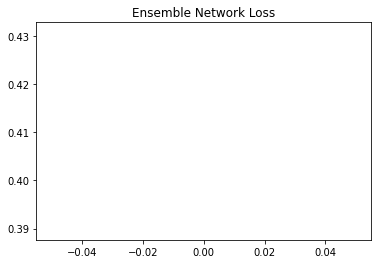

Confusion Matrix [[3982  283]
 [ 449 3795]]
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      4265
         1.0       0.93      0.89      0.91      4244

    accuracy                           0.91      8509
   macro avg       0.91      0.91      0.91      8509
weighted avg       0.91      0.91      0.91      8509



In [0]:
train_network(10, filename=f_folder+"model.pt")

#### Run 2

In [0]:
train_network(40, filename=f_folder+"model2.pt")

loaded
Models loaded, Training Network
Epoch: 1
Batch 0
Loss: 0.4102341706740266
Batch 50
Loss: 0.40993588241194023
Batch 100
Loss: 0.4094396253302174
Epoch: 2
Batch 0
Loss: 0.4093215165897219
Batch 50
Loss: 0.40903310351019717
Batch 100
Loss: 0.4087097648799838
Epoch: 3
Batch 0
Loss: 0.40849579507485034
Batch 50
Loss: 0.4082464747356646
Batch 100
Loss: 0.408061928468592
Epoch: 4
Batch 0
Loss: 0.4078279866418327
Batch 50
Loss: 0.40771162436373504
Batch 100
Loss: 0.40738812711677197
Epoch: 5
Batch 0
Loss: 0.4071943034025634
Batch 50
Loss: 0.407030509430954
Batch 100
Loss: 0.4068252610711576
Epoch: 6
Batch 0
Loss: 0.40663299519100926
Batch 50
Loss: 0.40660494376881173
Batch 100
Loss: 0.4065432883035915
Epoch: 7
Batch 0
Loss: 0.4062493618081479
Batch 50
Loss: 0.4062211269992519
Batch 100
Loss: 0.40600470983586856
Epoch: 8
Batch 0
Loss: 0.4058997671072583
Batch 50
Loss: 0.40563221324082327
Batch 100
Loss: 0.4054585669055802
Epoch: 9
Batch 0
Loss: 0.4054944507895757
Batch 50
Loss: 0.4053531

KeyboardInterrupt: ignored

#### Run 3

loaded
Models loaded, Training Network
Epoch: 1
Batch 0
Loss: 0.41786762941329875
Batch 50
Loss: 0.41756753651425244
Epoch: 2
Batch 0
Loss: 0.41737907070660846
Batch 50
Loss: 0.4170211733218269
Epoch: 3
Batch 0
Loss: 0.41693125644815154
Batch 50
Loss: 0.4168067250198359
Epoch: 4
Batch 0
Loss: 0.4165559082484212
Batch 50
Loss: 0.41643594008468854
Epoch: 5
Batch 0
Loss: 0.41617865923387126
Batch 50
Loss: 0.4160089772620184


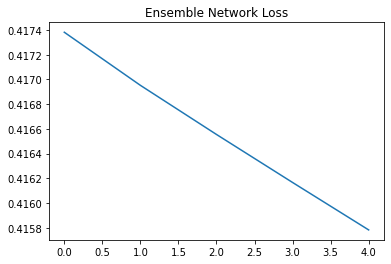

Confusion Matrix
 [[1301  136]
 [  86  202]]
TN: 1301  FP: 136  FN: 86  TP: 202
TPR:  0.7013888888888888
PPV:  0.5976331360946746
TNR:  0.9379956741167988
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      1437
         1.0       0.60      0.70      0.65       288

    accuracy                           0.87      1725
   macro avg       0.77      0.80      0.78      1725
weighted avg       0.88      0.87      0.88      1725



In [0]:
train_network(5, filename=f_folder+"model4.pt")

### Run 4

created
Models loaded, Training Network
Epoch: 1
Batch 0
Loss: 0.6946644186973572
Batch 50
Loss: 0.6103350116926081
Epoch: 2
Batch 0
Loss: 0.5400215579403771
Batch 50
Loss: 0.49919867047241756
Epoch: 3
Batch 0
Loss: 0.48627034928545604
Batch 50
Loss: 0.4740698757910833
Epoch: 4
Batch 0
Loss: 0.467639970245646
Batch 50
Loss: 0.4622031971343658
Epoch: 5
Batch 0
Loss: 0.45750934211145927
Batch 50
Loss: 0.45417060862302194
Epoch: 6
Batch 0
Loss: 0.45159947484598034
Batch 50
Loss: 0.44922750058674044
Epoch: 7
Batch 0
Loss: 0.4475719718175514
Batch 50
Loss: 0.44594831390258594
Epoch: 8
Batch 0
Loss: 0.4446030943535077
Batch 50
Loss: 0.44358127093279753
Epoch: 9
Batch 0
Loss: 0.44238885919475956
Batch 50
Loss: 0.44158980430031824
Epoch: 10
Batch 0
Loss: 0.4405472093538156
Batch 50
Loss: 0.4396834547321002
Epoch: 11
Batch 0
Loss: 0.4389897114299363
Batch 50
Loss: 0.43800368262148054
Epoch: 12
Batch 0
Loss: 0.43775748266857495
Batch 50
Loss: 0.4372451943679921
Epoch: 13
Batch 0
Loss: 0.43678056

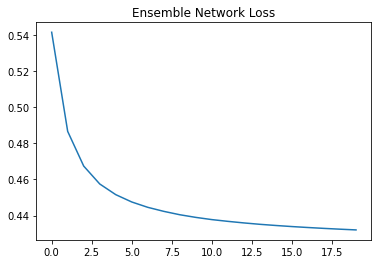

Confusion Matrix
 [[1293  144]
 [  79  209]]
TN: 1293  FP: 144  FN: 79  TP: 209
TPR:  0.7256944444444444
PPV:  0.5920679886685553
TNR:  0.9424198250728864
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1437
         1.0       0.59      0.73      0.65       288

    accuracy                           0.87      1725
   macro avg       0.77      0.81      0.79      1725
weighted avg       0.88      0.87      0.88      1725



In [48]:
train_network(20, filename=f_folder+"model5.pt")